In [13]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from time import time
from random import random

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import sys, os
import shutil
import csv

from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from pyspark.sql import HiveContext, SQLContext

from pyspark.sql.functions import * #explode, udf, to_date, concat, col, lit
from pyspark.sql import functions as F

#from pyspark.sql.types import StructType, StructField, IntegerType, StringType,FloatType,DoubleType
from pyspark.sql.types import *

from pyspark.sql.window import Window
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler, MinMaxScaler
from pyspark.ml.pipeline import Pipeline



#initialize the spark session
conf = SparkConf().setAppName('Predict')
#sc = SparkContext(conf=conf)
#sqlContext = SQLContext(sc)
#sc.setLogLevel('ERROR')

spark = SparkSession \
    .builder \
    .appName("Spark-PredictLogistic")\
	.config("spark.some.config.option", "some-value")\
    .getOrCreate()

In [14]:
# https://www.kaggle.com/c/avazu-ctr-prediction/data
target = 'click'

df= spark.read.csv("train.gz",header=True,mode="DROPMALFORMED")
df.printSchema()
#print('nrows:',df.count())

root
 |-- id: string (nullable = true)
 |-- click: string (nullable = true)
 |-- hour: string (nullable = true)
 |-- C1: string (nullable = true)
 |-- banner_pos: string (nullable = true)
 |-- site_id: string (nullable = true)
 |-- site_domain: string (nullable = true)
 |-- site_category: string (nullable = true)
 |-- app_id: string (nullable = true)
 |-- app_domain: string (nullable = true)
 |-- app_category: string (nullable = true)
 |-- device_id: string (nullable = true)
 |-- device_ip: string (nullable = true)
 |-- device_model: string (nullable = true)
 |-- device_type: string (nullable = true)
 |-- device_conn_type: string (nullable = true)
 |-- C14: string (nullable = true)
 |-- C15: string (nullable = true)
 |-- C16: string (nullable = true)
 |-- C17: string (nullable = true)
 |-- C18: string (nullable = true)
 |-- C19: string (nullable = true)
 |-- C20: string (nullable = true)
 |-- C21: string (nullable = true)



In [15]:
#DROP COLS
df = df.drop('id','device_id','device_ip','device_model')

### Sample 5% of data for Quick Testing

In [16]:
df = df.sample(False,0.05,1234)
#print('sampled nrows:',df.count())

In [17]:
# check dates
df.select('hour').show(5)


# clean dates
df = df.withColumn('date', concat(df.hour.substr(0, 2),
                                  lit('-'),df.hour.substr(3,2),
                                  lit('-'),df.hour.substr(5,2),
                                 ))

df = df.withColumn('hour', concat(df.hour.substr(7,2)))

df = df.withColumn('date',to_timestamp('date','yy-MM-dd'))
#df = df.where(col("date").isNotNull())
    
df.select('hour','date').show(5)
df.printSchema()

+--------+
|    hour|
+--------+
|14102100|
|14102100|
|14102100|
|14102100|
|14102100|
+--------+
only showing top 5 rows

+----+-------------------+
|hour|               date|
+----+-------------------+
|  00|2014-10-21 00:00:00|
|  00|2014-10-21 00:00:00|
|  00|2014-10-21 00:00:00|
|  00|2014-10-21 00:00:00|
|  00|2014-10-21 00:00:00|
+----+-------------------+
only showing top 5 rows

root
 |-- click: string (nullable = true)
 |-- hour: string (nullable = true)
 |-- C1: string (nullable = true)
 |-- banner_pos: string (nullable = true)
 |-- site_id: string (nullable = true)
 |-- site_domain: string (nullable = true)
 |-- site_category: string (nullable = true)
 |-- app_id: string (nullable = true)
 |-- app_domain: string (nullable = true)
 |-- app_category: string (nullable = true)
 |-- device_type: string (nullable = true)
 |-- device_conn_type: string (nullable = true)
 |-- C14: string (nullable = true)
 |-- C15: string (nullable = true)
 |-- C16: string (nullable = true)
 |-- C1

### Date Features: day

In [18]:
from datetime import datetime, timedelta
from time import time
#from pyspark.sql.functions import date_format,hour

df = df.withColumn("day",date_format('date', 'E') )
df.select('date','day').show(5)

+-------------------+---+
|               date|day|
+-------------------+---+
|2014-10-21 00:00:00|Tue|
|2014-10-21 00:00:00|Tue|
|2014-10-21 00:00:00|Tue|
|2014-10-21 00:00:00|Tue|
|2014-10-21 00:00:00|Tue|
+-------------------+---+
only showing top 5 rows



### Cast to Integers 

In [19]:
myint = [target,'hour','C1','banner_pos','device_conn_type',
        'C14','C15','C16','C17','C18','C19','C20','C21']

for i in myint:
    df = df.withColumn((i),df[i].cast('integer'))
    
df.printSchema()

root
 |-- click: integer (nullable = true)
 |-- hour: integer (nullable = true)
 |-- C1: integer (nullable = true)
 |-- banner_pos: integer (nullable = true)
 |-- site_id: string (nullable = true)
 |-- site_domain: string (nullable = true)
 |-- site_category: string (nullable = true)
 |-- app_id: string (nullable = true)
 |-- app_domain: string (nullable = true)
 |-- app_category: string (nullable = true)
 |-- device_type: string (nullable = true)
 |-- device_conn_type: integer (nullable = true)
 |-- C14: integer (nullable = true)
 |-- C15: integer (nullable = true)
 |-- C16: integer (nullable = true)
 |-- C17: integer (nullable = true)
 |-- C18: integer (nullable = true)
 |-- C19: integer (nullable = true)
 |-- C20: integer (nullable = true)
 |-- C21: integer (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- day: string (nullable = true)



### Check unusual counts for app_id & site_id:
* bid_request data can either be from a website or app but never both

In [20]:
df = df.withColumn("count", lit(1))
app_stats = df.groupBy('app_id').agg({"count": "sum"})
app_stats = app_stats.orderBy('sum(count)',ascending=False)
app_stats.show()

+--------+----------+
|  app_id|sum(count)|
+--------+----------+
|ecad2386|   1292734|
|92f5800b|     77823|
|e2fcccd2|     56670|
|9c13b419|     38294|
|febd1138|     38029|
|7358e05e|     30642|
|a5184c22|     24377|
|d36838b1|     23086|
|685d1c4c|     20440|
|54c5d545|     19821|
|03528b27|     16131|
|f0d41ff1|     14668|
|e9739828|     14308|
|e2a1ca37|     14117|
|51cedd4e|     11940|
|66f5e02e|     11447|
|03a08c3f|     10940|
|98fed791|     10815|
|73206397|      9998|
|f53417e1|      9983|
+--------+----------+
only showing top 20 rows



In [21]:
site_stats = df.groupBy('site_id').agg({"count": "sum"})
site_stats = site_stats.orderBy('sum(count)',ascending=False)
site_stats.show()

+--------+----------+
| site_id|sum(count)|
+--------+----------+
|85f751fd|    730254|
|1fbe01fe|    323916|
|e151e245|    132007|
|d9750ee7|     48731|
|5b08c53b|     45865|
|856e6d3f|     38242|
|5b4d2eda|     38169|
|a7853007|     23174|
|b7e9786d|     18453|
|5ee41ff2|     17540|
|6399eda6|     17281|
|5bcf81a2|     17085|
|6256f5b4|     15879|
|57ef2c87|     15556|
|17caea14|     13729|
|0a742914|     13533|
|83a0ad1a|     13458|
|e4d8dd7b|     13224|
|57fe1b20|     13201|
|e8f79e60|     13123|
+--------+----------+
only showing top 20 rows



In [22]:
df.select('site_id','app_id','site_domain','app_domain','site_category','app_category')\
  .filter(df['app_id']=='ecad2386').show()

+--------+--------+-----------+----------+-------------+------------+
| site_id|  app_id|site_domain|app_domain|site_category|app_category|
+--------+--------+-----------+----------+-------------+------------+
|1fbe01fe|ecad2386|   f3845767|  7801e8d9|     28905ebd|    07d7df22|
|0c2fe9d6|ecad2386|   27e3c518|  7801e8d9|     28905ebd|    07d7df22|
|1fbe01fe|ecad2386|   f3845767|  7801e8d9|     28905ebd|    07d7df22|
|1fbe01fe|ecad2386|   f3845767|  7801e8d9|     28905ebd|    07d7df22|
|1fbe01fe|ecad2386|   f3845767|  7801e8d9|     28905ebd|    07d7df22|
|e151e245|ecad2386|   7e091613|  7801e8d9|     f028772b|    07d7df22|
|1fbe01fe|ecad2386|   f3845767|  7801e8d9|     28905ebd|    07d7df22|
|1fbe01fe|ecad2386|   f3845767|  7801e8d9|     28905ebd|    07d7df22|
|43d6df75|ecad2386|   27e3c518|  7801e8d9|     28905ebd|    07d7df22|
|e59ef3fc|ecad2386|   0a4015b2|  7801e8d9|     335d28a8|    07d7df22|
|1fbe01fe|ecad2386|   f3845767|  7801e8d9|     28905ebd|    07d7df22|
|1fbe01fe|ecad2386| 

In [23]:
df.select('site_id','app_id','site_domain','app_domain','site_category','app_category')\
  .filter(df['site_id']=='85f751fd').show()

+--------+--------+-----------+----------+-------------+------------+
| site_id|  app_id|site_domain|app_domain|site_category|app_category|
+--------+--------+-----------+----------+-------------+------------+
|85f751fd|e2a1ca37|   c4e18dd6|  2347f47a|     50e219e0|    8ded1f7a|
|85f751fd|e2fcccd2|   c4e18dd6|  5c5a694b|     50e219e0|    0f2161f8|
|85f751fd|ffc6ffd0|   c4e18dd6|  7801e8d9|     50e219e0|    0f2161f8|
|85f751fd|febd1138|   c4e18dd6|  82e27996|     50e219e0|    0f2161f8|
|85f751fd|1779deee|   c4e18dd6|  2347f47a|     50e219e0|    f95efa07|
|85f751fd|0acbeaa3|   c4e18dd6|  45a51db4|     50e219e0|    f95efa07|
|85f751fd|39947756|   c4e18dd6|  2347f47a|     50e219e0|    cef3e649|
|85f751fd|1779deee|   c4e18dd6|  2347f47a|     50e219e0|    f95efa07|
|85f751fd|51cedd4e|   c4e18dd6|  aefc06bd|     50e219e0|    0f2161f8|
|85f751fd|4e02fbd3|   c4e18dd6|  7801e8d9|     50e219e0|    07d7df22|
|85f751fd|090d3a47|   c4e18dd6|  0654b444|     50e219e0|    0f2161f8|
|85f751fd|39947756| 

### Create new feature:  source_id & source_domain
* each row can only consist of either a site or an app( never both)
* site_id = 85f751fd indicates it is not a site but an app
* app_id = ecad2386 indicates it is not an app but a site

### New Feature: source_id

In [24]:
# feature SOURCE_ID
df = df.withColumn('source_id',
                   F.when(df['app_id']=='ecad2386',df['site_id'])\
                    .when(df['site_id']=='85f751fd',df['app_id'])\
                  )

df.select('source_id','app_id','site_id','app_domain').show()

+---------+--------+--------+----------+
|source_id|  app_id| site_id|app_domain|
+---------+--------+--------+----------+
| 1fbe01fe|ecad2386|1fbe01fe|  7801e8d9|
| 0c2fe9d6|ecad2386|0c2fe9d6|  7801e8d9|
| 1fbe01fe|ecad2386|1fbe01fe|  7801e8d9|
| e2a1ca37|e2a1ca37|85f751fd|  2347f47a|
| 1fbe01fe|ecad2386|1fbe01fe|  7801e8d9|
| 1fbe01fe|ecad2386|1fbe01fe|  7801e8d9|
| e151e245|ecad2386|e151e245|  7801e8d9|
| e2fcccd2|e2fcccd2|85f751fd|  5c5a694b|
| 1fbe01fe|ecad2386|1fbe01fe|  7801e8d9|
| 1fbe01fe|ecad2386|1fbe01fe|  7801e8d9|
| ffc6ffd0|ffc6ffd0|85f751fd|  7801e8d9|
| 43d6df75|ecad2386|43d6df75|  7801e8d9|
| e59ef3fc|ecad2386|e59ef3fc|  7801e8d9|
| 1fbe01fe|ecad2386|1fbe01fe|  7801e8d9|
| 1fbe01fe|ecad2386|1fbe01fe|  7801e8d9|
| 543a539e|ecad2386|543a539e|  7801e8d9|
| 1fbe01fe|ecad2386|1fbe01fe|  7801e8d9|
| febd1138|febd1138|85f751fd|  82e27996|
| 1fbe01fe|ecad2386|1fbe01fe|  7801e8d9|
| 1fbe01fe|ecad2386|1fbe01fe|  7801e8d9|
+---------+--------+--------+----------+
only showing top

### New Feature: source_domain

In [25]:
# feature SOURCE_DOMAIN
df = df.withColumn('source_domain',F.when(df['app_id']=='ecad2386',df['site_domain'])\
                                    .when(df['site_id']=='85f751fd',df['app_domain']))

df.select('source_domain','app_domain','site_domain','app_id','site_id').show()

+-------------+----------+-----------+--------+--------+
|source_domain|app_domain|site_domain|  app_id| site_id|
+-------------+----------+-----------+--------+--------+
|     f3845767|  7801e8d9|   f3845767|ecad2386|1fbe01fe|
|     27e3c518|  7801e8d9|   27e3c518|ecad2386|0c2fe9d6|
|     f3845767|  7801e8d9|   f3845767|ecad2386|1fbe01fe|
|     2347f47a|  2347f47a|   c4e18dd6|e2a1ca37|85f751fd|
|     f3845767|  7801e8d9|   f3845767|ecad2386|1fbe01fe|
|     f3845767|  7801e8d9|   f3845767|ecad2386|1fbe01fe|
|     7e091613|  7801e8d9|   7e091613|ecad2386|e151e245|
|     5c5a694b|  5c5a694b|   c4e18dd6|e2fcccd2|85f751fd|
|     f3845767|  7801e8d9|   f3845767|ecad2386|1fbe01fe|
|     f3845767|  7801e8d9|   f3845767|ecad2386|1fbe01fe|
|     7801e8d9|  7801e8d9|   c4e18dd6|ffc6ffd0|85f751fd|
|     27e3c518|  7801e8d9|   27e3c518|ecad2386|43d6df75|
|     0a4015b2|  7801e8d9|   0a4015b2|ecad2386|e59ef3fc|
|     f3845767|  7801e8d9|   f3845767|ecad2386|1fbe01fe|
|     f3845767|  7801e8d9|   f3

### New Feature: source_category

In [26]:
# feature SOURCE_category
df = df.withColumn('source_category',F.when(df['app_id']=='ecad2386',df['site_category'])\
                                    .when(df['site_id']=='85f751fd',df['app_category']))

df.select('source_category','app_category','app_id','site_id').show()

+---------------+------------+--------+--------+
|source_category|app_category|  app_id| site_id|
+---------------+------------+--------+--------+
|       28905ebd|    07d7df22|ecad2386|1fbe01fe|
|       28905ebd|    07d7df22|ecad2386|0c2fe9d6|
|       28905ebd|    07d7df22|ecad2386|1fbe01fe|
|       8ded1f7a|    8ded1f7a|e2a1ca37|85f751fd|
|       28905ebd|    07d7df22|ecad2386|1fbe01fe|
|       28905ebd|    07d7df22|ecad2386|1fbe01fe|
|       f028772b|    07d7df22|ecad2386|e151e245|
|       0f2161f8|    0f2161f8|e2fcccd2|85f751fd|
|       28905ebd|    07d7df22|ecad2386|1fbe01fe|
|       28905ebd|    07d7df22|ecad2386|1fbe01fe|
|       0f2161f8|    0f2161f8|ffc6ffd0|85f751fd|
|       28905ebd|    07d7df22|ecad2386|43d6df75|
|       335d28a8|    07d7df22|ecad2386|e59ef3fc|
|       28905ebd|    07d7df22|ecad2386|1fbe01fe|
|       28905ebd|    07d7df22|ecad2386|1fbe01fe|
|       3e814130|    07d7df22|ecad2386|543a539e|
|       28905ebd|    07d7df22|ecad2386|1fbe01fe|
|       0f2161f8|   

### feature C15 & C16 shows banner W & H 

In [27]:
df.select('C15','C16').distinct().show()

+----+----+
| C15| C16|
+----+----+
| 300|  50|
| 320| 480|
| 768|1024|
| 320|  50|
| 480| 320|
| 300| 250|
| 120|  20|
|1024| 768|
| 728|  90|
| 216|  36|
+----+----+



### New  Categorical Feature: banner_size

In [28]:
df = df.withColumn('banner_size',concat(df.C15,lit('x'),df.C16))

df.select('banner_size').show(5)

+-----------+
|banner_size|
+-----------+
|     320x50|
|     320x50|
|     320x50|
|     320x50|
|     320x50|
+-----------+
only showing top 5 rows



In [29]:
df = df.drop('site_id','site_domain','app_id','app_domain',
             'site_category','app_category',
             'C15','C16','count')
df.printSchema()

root
 |-- click: integer (nullable = true)
 |-- hour: integer (nullable = true)
 |-- C1: integer (nullable = true)
 |-- banner_pos: integer (nullable = true)
 |-- device_type: string (nullable = true)
 |-- device_conn_type: integer (nullable = true)
 |-- C14: integer (nullable = true)
 |-- C17: integer (nullable = true)
 |-- C18: integer (nullable = true)
 |-- C19: integer (nullable = true)
 |-- C20: integer (nullable = true)
 |-- C21: integer (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- day: string (nullable = true)
 |-- source_id: string (nullable = true)
 |-- source_domain: string (nullable = true)
 |-- source_category: string (nullable = true)
 |-- banner_size: string (nullable = true)



### Other Features Engineering

In [30]:
df = (df
      .withColumn('pos_conn_type',concat(df['banner_pos'],lit('_'),df['device_conn_type']))
      .withColumn('source_id_pos',concat(df['source_id'],lit('_'),df['banner_pos']  ))
     )

df.select('pos_conn_type','source_id_pos').show()
df.printSchema()

+-------------+-------------+
|pos_conn_type|source_id_pos|
+-------------+-------------+
|          0_0|   1fbe01fe_0|
|          1_0|   0c2fe9d6_1|
|          0_0|   1fbe01fe_0|
|          0_0|   e2a1ca37_0|
|          0_0|   1fbe01fe_0|
|          0_0|   1fbe01fe_0|
|          1_0|   e151e245_1|
|          0_0|   e2fcccd2_0|
|          0_0|   1fbe01fe_0|
|          0_0|   1fbe01fe_0|
|          1_0|   ffc6ffd0_1|
|          1_0|   43d6df75_1|
|          1_0|   e59ef3fc_1|
|          0_0|   1fbe01fe_0|
|          0_2|   1fbe01fe_0|
|          0_0|   543a539e_0|
|          0_0|   1fbe01fe_0|
|          0_0|   febd1138_0|
|          0_0|   1fbe01fe_0|
|          0_0|   1fbe01fe_0|
+-------------+-------------+
only showing top 20 rows

root
 |-- click: integer (nullable = true)
 |-- hour: integer (nullable = true)
 |-- C1: integer (nullable = true)
 |-- banner_pos: integer (nullable = true)
 |-- device_type: string (nullable = true)
 |-- device_conn_type: integer (nullable = true)
 |--

In [31]:
#============= Convert to String (categorical)=======================
df = df.withColumn("C1", df["C1"].cast("string"))
df.printSchema()

root
 |-- click: integer (nullable = true)
 |-- hour: integer (nullable = true)
 |-- C1: string (nullable = true)
 |-- banner_pos: integer (nullable = true)
 |-- device_type: string (nullable = true)
 |-- device_conn_type: integer (nullable = true)
 |-- C14: integer (nullable = true)
 |-- C17: integer (nullable = true)
 |-- C18: integer (nullable = true)
 |-- C19: integer (nullable = true)
 |-- C20: integer (nullable = true)
 |-- C21: integer (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- day: string (nullable = true)
 |-- source_id: string (nullable = true)
 |-- source_domain: string (nullable = true)
 |-- source_category: string (nullable = true)
 |-- banner_size: string (nullable = true)
 |-- pos_conn_type: string (nullable = true)
 |-- source_id_pos: string (nullable = true)



### Model Specifications

In [34]:
#==============  target label ==================
print('target:',target,'\n')
print('===================== X_category =============================')

X_category = ['hour',
              'C14',
              'C20',
              'source_id_pos', 
              'day',
              'source_domain',
              'C17',
              'C19',
              'C21',
              'source_category',
              'device_conn_type',
              'pos_conn_type',
              'C18',
              'banner_pos',
              'C1', 
              'banner_size',
              'device_type'
             ]

print('X_category:',X_category)

string = '_dummy'
X_dummy = [x + string for x in X_category]

print ("\nX_dummy:",X_dummy)


target: click 

===================== X_category =============================
X_category: ['hour', 'C14', 'C20', 'source_id_pos', 'day', 'source_domain', 'C17', 'C19', 'C21', 'source_category', 'device_conn_type', 'pos_conn_type', 'C18', 'banner_pos', 'C1', 'banner_size', 'device_type']

X_dummy: ['hour_dummy', 'C14_dummy', 'C20_dummy', 'source_id_pos_dummy', 'day_dummy', 'source_domain_dummy', 'C17_dummy', 'C19_dummy', 'C21_dummy', 'source_category_dummy', 'device_conn_type_dummy', 'pos_conn_type_dummy', 'C18_dummy', 'banner_pos_dummy', 'C1_dummy', 'banner_size_dummy', 'device_type_dummy']


### Data Preparation:
* One hot encoding of categorical cols
* Assembly & Pipeline 

In [35]:
print ('======================= assembly & pipeline =================================')
from pyspark.ml.feature import OneHotEncoder, StringIndexer
from pyspark.ml.pipeline import Pipeline
from pyspark.ml.feature import VectorAssembler


column_vec_in = X_category
column_vec_out = X_dummy

indexers = [StringIndexer(inputCol=x, outputCol=x+'_tmp')
        for x in column_vec_in ]

encoders = [OneHotEncoder(dropLast=True,#False,
                      inputCol=x+"_tmp",
                      outputCol=y)

for x,y in zip(column_vec_in, column_vec_out)]


tmp = [[i,j] for i,j in zip(indexers, encoders)]
tmp = [i for sublist in tmp for i in sublist]
list(tmp)


# prepare target labeled set, NOTE: target inputCol CANNOT be the same name as outputCol
cols_now = X_dummy #+  X_numeric

print ('cols selected:',cols_now)

assembler_features = VectorAssembler(inputCols=cols_now, outputCol='features')

labelIndexer = StringIndexer(inputCol=target, outputCol="label")

tmp += [assembler_features, labelIndexer]
pipeline = Pipeline(stages=tmp)

df_tr = pipeline.fit(df).transform(df)
df_tr.cache()
df.unpersist()

======================= assembly & pipeline =================================
cols selected: ['hour_dummy', 'C14_dummy', 'C20_dummy', 'source_id_pos_dummy', 'day_dummy', 'source_domain_dummy', 'C17_dummy', 'C19_dummy', 'C21_dummy', 'source_category_dummy', 'device_conn_type_dummy', 'pos_conn_type_dummy', 'C18_dummy', 'banner_pos_dummy', 'C1_dummy', 'banner_size_dummy', 'device_type_dummy']


DataFrame[click: int, hour: int, C1: string, banner_pos: int, device_type: string, device_conn_type: int, C14: int, C17: int, C18: int, C19: int, C20: int, C21: int, date: timestamp, day: string, source_id: string, source_domain: string, source_category: string, banner_size: string, pos_conn_type: string, source_id_pos: string]

### Data Partitioning:
* Train/Test Split

In [36]:
#=============  partition train test by dates ===============

### Randomly split data into training and test sets. set seed for reproducibility

ratio_partition = 0.8

(train, test) = df_tr.randomSplit([ratio_partition,1-ratio_partition], seed=10) # need to ensure same split for each time

train.cache()
test.cache()
df_tr.unpersist()

DataFrame[click: int, hour: int, C1: string, banner_pos: int, device_type: string, device_conn_type: int, C14: int, C17: int, C18: int, C19: int, C20: int, C21: int, date: timestamp, day: string, source_id: string, source_domain: string, source_category: string, banner_size: string, pos_conn_type: string, source_id_pos: string, hour_tmp: double, hour_dummy: vector, C14_tmp: double, C14_dummy: vector, C20_tmp: double, C20_dummy: vector, source_id_pos_tmp: double, source_id_pos_dummy: vector, day_tmp: double, day_dummy: vector, source_domain_tmp: double, source_domain_dummy: vector, C17_tmp: double, C17_dummy: vector, C19_tmp: double, C19_dummy: vector, C21_tmp: double, C21_dummy: vector, source_category_tmp: double, source_category_dummy: vector, device_conn_type_tmp: double, device_conn_type_dummy: vector, pos_conn_type_tmp: double, pos_conn_type_dummy: vector, C18_tmp: double, C18_dummy: vector, banner_pos_tmp: double, banner_pos_dummy: vector, C1_tmp: double, C1_dummy: vector, banner

### Training: Logistic Regression (elasticNet)
* elastic-net penalty = 0.9 (mixes both ridge & lasso regression approach)
* CV fold = 10
* Regularization Parameter 

Logistic Regression is used for its interpretability of the specified features used in training. This helps the end-user to understand what drives the positive response. Thus useful for debugging in real world situations.

Secondly its also a fast model that scales well with big data depending on the available computation settings.

In [37]:
print ('====================== LogisticRegression ================================')


myCVfold = 10


#=======================  CROSS VALIDATION MODEL (TRAINING) ===================================================

from pyspark.ml.evaluation import (BinaryClassificationEvaluator, MulticlassClassificationEvaluator)

#==================== LogisticRegression ===================================

#elasticNetParam corresponds to α and regParam corresponds to λ.
from pyspark.ml.classification  import (LogisticRegression,LogisticRegressionModel)


lr = LogisticRegression(labelCol="label", featuresCol="features")

#setWeightCol(java.lang.String value)
#Whether to over-/under-sample training instances according to the given weights in weightCol. 
#If empty, all instances are treated equally (weight 1.0). 
#Default is empty, so all instances have weight one.



#============ parameter tuning ==================
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Create ParamGrid for Cross Validation
paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.00001])#  lambda: Increasing lambda results in less overfitting but also greater bias
             .addGrid(lr.elasticNetParam, [0.9]) # aplha: 1=lasso(L1), 0=Ridge(L2)
             .addGrid(lr.maxIter, [10]) 
             .build())



# CrossValidator
evaluator = BinaryClassificationEvaluator(labelCol="label", 
                                          rawPredictionCol="probability",
                                          metricName="areaUnderROC")

cv = CrossValidator(estimator=lr, 
                    estimatorParamMaps=paramGrid, 
                    evaluator=evaluator, 
                    numFolds=myCVfold)

# Run cross validations
cvModel = cv.fit(train)



#======= Predictions ===================
predictions = cvModel.transform(test)
print("Crossvalidated AUC",cvModel.avgMetrics)


====================== LogisticRegression ================================
Crossvalidated AUC [0.7398033366137504]


In [38]:
coef_filename = 'myCoef.csv'

print ('========================= EXTRACT COEFFICIENTS ====================================')
coeff = list(cvModel.bestModel.coefficients)
names_binary = predictions.schema["features"].metadata["ml_attr"]["attrs"]['binary']
#names_numeric = predictions.schema["features"].metadata["ml_attr"]["attrs"]['numeric']


predictor = ["(Intercept)"]
coefficient = [cvModel.bestModel.intercept]

#binary coef
for e in names_binary:
    name_dummy = e['name']
    name_list = name_dummy.split('_dummy_')
    name = name_list[0] + name_list[1]
    predictor.append(name)
    index = e['idx']
    coefficient.append(coeff[index])  

    
"""
for e in names_numeric:
    name = e['name']
    predictor.append(name)
    index = e['idx']
    coefficient.append(coeff[index])

"""
#numeric coef 

    
#print(predictor)

#===============WRITE COEF TO CSV===============
import pandas as pd
coef_df = pd.DataFrame({"predictor": predictor, "coefficient":coefficient})
coef_df = coef_df[['predictor', 'coefficient']]
coef_df = coef_df[(coef_df["coefficient"]!=0)]
coef_df.to_csv(coef_filename, index=None, quoting=csv.QUOTE_NONNUMERIC)
coef_df = coef_df.sort_values(['coefficient'], ascending=[False])


print (coef_df)
print ('WRITE COEF TO CSV Completed!')
print ('n_coefs:',len(coef_df))

========================= EXTRACT COEFFICIENTS ====================================
                     predictor  coefficient
2303                  C1422476     8.665981
9183   source_id_pos3e94f372_0     8.340196
7183   source_id_posa61ffded_0     8.254146
8857   source_id_posab1be368_0     8.170403
7501   source_id_posfaadbc8d_1     8.168548
9419   source_id_posaddcd577_0     8.035993
7495   source_id_posdd954e91_1     8.014800
6251   source_id_pos5a82fca1_0     7.961589
8799   source_id_pos0c2fe9d6_0     7.913367
8594   source_id_pos8e7b1f22_0     7.871456
6678   source_id_pos16c73019_0     7.864588
9374   source_id_posc4c44801_0     7.857936
8334   source_id_posb5f3f72a_0     7.798780
8617   source_id_pos89c3d2bf_0     7.761080
7385   source_id_pos73ea5117_0     7.747371
8764   source_id_posa2ff3fa3_0     7.744195
8389   source_id_posde0a2044_0     7.646402
7537   source_id_pos16c382c3_1     7.638133
8188   source_id_posff57e892_0     7.636985
8603   source_id_pos85234e31_0     7

In [39]:
from pyspark.sql.types import FloatType
from pyspark.sql.functions import lit, udf

def ith_(v):
    try:
        return float(v[1])
    except ValueError:
        return None

ith = udf(ith_, FloatType())

obs_pred = predictions.select('label','probability').cache()
obs_pred = obs_pred.withColumn("p", ith(obs_pred["probability"]))
obs_pred = obs_pred.select('label','p')
obs_pred = obs_pred.withColumn("label", obs_pred["label"].cast("integer"))

obs_pred.printSchema()
obs_pred.show(10)

root
 |-- label: integer (nullable = true)
 |-- p: float (nullable = true)

+-----+-----------+
|label|          p|
+-----+-----------+
|    0| 0.02210474|
|    0|0.092492245|
|    0|  0.1631121|
|    0| 0.14496608|
|    0|   0.186824|
|    0| 0.52342117|
|    0|  0.2788509|
|    0| 0.15721294|
|    0|  0.3179442|
|    0|0.025307272|
+-----+-----------+
only showing top 10 rows



In [40]:
print ('================= Model Evaluation: AUC & Logloss ==================================')
from sklearn import metrics
from sklearn.metrics import log_loss

obs_pred=obs_pred.toPandas()

obs = obs_pred['label']
pred = obs_pred['p']

fpr, tpr, thresholds = metrics.roc_curve(obs, pred)

#print('tpr:',tpr)
#print('fpr:',fpr)

auc = metrics.auc(fpr,tpr)
logloss_score = log_loss(obs, pred, eps=1e-15)

interceptCTR = 1/(1+np.exp(-(cvModel.bestModel.intercept)))

print ('AUC =', auc)
print ('logloss =', logloss_score)

================= Model Evaluation: AUC & Logloss ==================================
AUC = 0.7406146477004849
logloss = 0.40054929480173534


Features:
 ['hour', 'C14', 'C20', 'source_id_pos', 'day', 'source_domain', 'C17', 'C19', 'C21', 'source_category', 'device_conn_type', 'pos_conn_type', 'C18', 'banner_pos', 'C1', 'banner_size', 'device_type']

interceptCTR(defaultCTR): 0.170021811989151


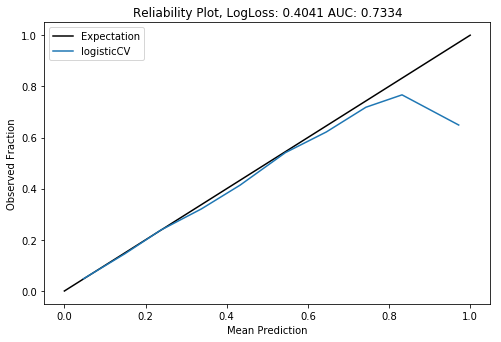

In [44]:
#=================== reliability plots ===========================

import numpy as np
import matplotlib.pyplot as plt
get_ipython().magic(u'matplotlib inline')

def reliability_curve(y_true, y_score, bins=10, normalize=False):
    """Compute reliability curve

    Reliability curves allow checking if the predicted probabilities of a
    binary classifier are well calibrated. This function returns two arrays
    which encode a mapping from predicted probability to empirical probability.
    For this, the predicted probabilities are partitioned into equally sized
    bins and the mean predicted probability and the mean empirical probabilties
    in the bins are computed. For perfectly calibrated predictions, both
    quantities whould be approximately equal (for sufficiently many test
    samples).

    Note: this implementation is restricted to binary classification.

    Parameters
    ----------

    y_true : array, shape = [n_samples]
        True binary labels (0 or 1).

    y_score : array, shape = [n_samples]
        Target scores, can either be probability estimates of the positive
        class or confidence values. If normalize is False, y_score must be in
        the interval [0, 1]

    bins : int, optional, default=10
        The number of bins into which the y_scores are partitioned.
        Note: n_samples should be considerably larger than bins such that
              there is sufficient data in each bin to get a reliable estimate
              of the reliability

    normalize : bool, optional, default=False
        Whether y_score needs to be normalized into the bin [0, 1]. If True,
        the smallest value in y_score is mapped onto 0 and the largest one
        onto 1.


    Returns
    -------
    y_score_bin_mean : array, shape = [bins]
        The mean predicted y_score in the respective bins.

    empirical_prob_pos : array, shape = [bins]
        The empirical probability (frequency) of the positive class (+1) in the
        respective bins.


    References
    ----------
    .. [1] `Predicting Good Probabilities with Supervised Learning
            <http://machinelearning.wustl.edu/mlpapers/paper_files/icml2005_Niculescu-MizilC05.pdf>`_

    """
    if normalize:  # Normalize scores into bin [0, 1]
        y_score = (y_score - y_score.min()) / (y_score.max() - y_score.min())

    bin_width = 1.0 / bins
    bin_centers = np.linspace(0, 1.0 - bin_width, bins) + bin_width / 2

    y_score_bin_mean = np.empty(bins)
    empirical_prob_pos = np.empty(bins)
    for i, threshold in enumerate(bin_centers):
        # determine all samples where y_score falls into the i-th bin
        bin_idx = np.logical_and(threshold - bin_width / 2 < y_score,
                                 y_score <= threshold + bin_width / 2)
        # Store mean y_score and mean empirical probability of positive class
        y_score_bin_mean[i] = y_score[bin_idx].mean()
        empirical_prob_pos[i] = y_true[bin_idx].mean()
    return y_score_bin_mean, empirical_prob_pos


# In[26]:


obs = obs_pred['label']
pred = obs_pred['p']


reliable_tuple = reliability_curve(obs, pred, bins=10, normalize=False)
y_score_bin_mean = reliable_tuple[0]
empirical_prob_pos = reliable_tuple[1]
plt.figure(0, figsize=(8, 8))
plt.subplot2grid((3, 1), (0, 0), rowspan=2)

#mytitle="Reliability Plot,"+" LogLoss: "+str(round(logloss_score,4))+" AUC: " + str(round(auc,4))

plt.title(mytitle)
plt.plot([0.0, 1.0], [0.0, 1.0], 'k', label="Expectation")

scores_not_nan = np.logical_not(np.isnan(empirical_prob_pos))
plt.plot(y_score_bin_mean[scores_not_nan],empirical_prob_pos[scores_not_nan], label='logisticCV')
plt.ylabel("Observed Fraction")
plt.xlabel("Mean Prediction")
plt.legend(loc=0)
print ('Features:\n',X_category)
print('\ninterceptCTR(defaultCTR):',interceptCTR)




In [ ]:
obs_pred.to_csv('forReliabilityPlotPyspark.csv', index = False, encoding = 'utf-8')
print ('forReliabilityPlotPyspark.csv DONE!')